# Exploratory Data Analysis on Text Data

Shamelessly taken from [neptune.ai](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
news = pd.read_csv("abcnews-date-text.csv", nrows=10000)

news.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [3]:
news.shape

(10000, 2)

### Character Count

<AxesSubplot:>

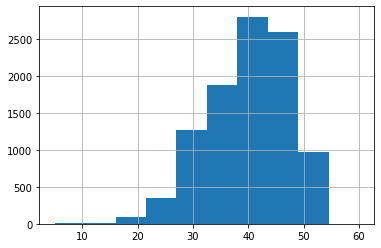

In [4]:
news['headline_text'].str.len().hist()

### Word Count

<AxesSubplot:>

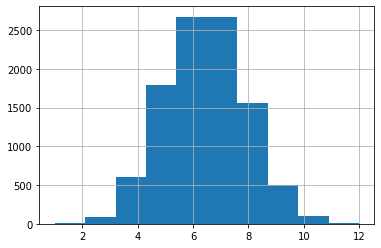

In [5]:
news['headline_text'].apply(lambda x: len(x.split())).hist()

### Most Common Stopwords

In [6]:
import nltk

In [7]:
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

In [8]:
corpus = []
new = news['headline_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

In [9]:
from collections import defaultdict

dic = defaultdict(int)
for word in corpus:
    if word in STOPWORDS:
        dic[word] += 1

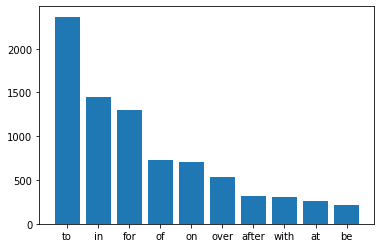

In [10]:
top10 = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top10)
plt.bar(x, y)
plt.show()

### Most Common Non-stopword word

In [11]:
from collections import Counter
import seaborn as sns

In [12]:
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if word not in STOPWORDS:
        x.append(word)
        y.append(count)

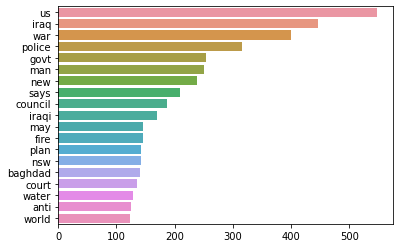

In [13]:
sns.barplot(x=y, y=x)
plt.show()

### Most Common N-gram Words 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
def get_top_ngram(corpus, n=1, top=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top]

<AxesSubplot:>

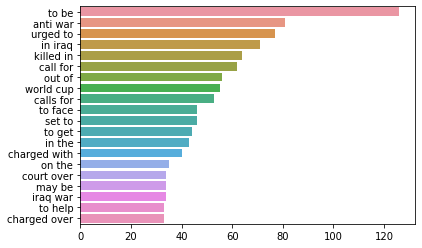

In [16]:
top_bigrams = get_top_ngram(news['headline_text'], n=2, top=20)
x, y = map(list, zip(*top_bigrams))

sns.barplot(x=y, y=x)

In [17]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

In [18]:
def preprocess_text(df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for news in df['headline_text']:
        words = [w for w in word_tokenize(news) if (w not in STOPWORDS)]
        words = [lem.lemmatize(w) for w in words if len(w) > 2]
        
        corpus.append(words)
    return corpus

corpus = preprocess_text(news)

In [19]:
import gensim

In [20]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [21]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                      num_topics=4,
                                      id2word=dic,
                                      passes=10,
                                      workers=2)

### Word Cloud

In [22]:
from wordcloud import WordCloud, STOPWORDS

In [23]:
stopwords = set(STOPWORDS)

In [31]:
def show_wordcloud(data):
    wordcloud = WordCloud(
                        background_color='white',
                        stopwords=STOPWORDS,
                        max_words=100,
                        max_font_size=45,
                        scale=3,
                        random_state=1
                        )
    wordcloud = wordcloud.generate(str(data))
    
    fig = plt.figure(figsize=(16, 16))
    plt.axis('off')
    
    plt.imshow(wordcloud)
    plt.show()

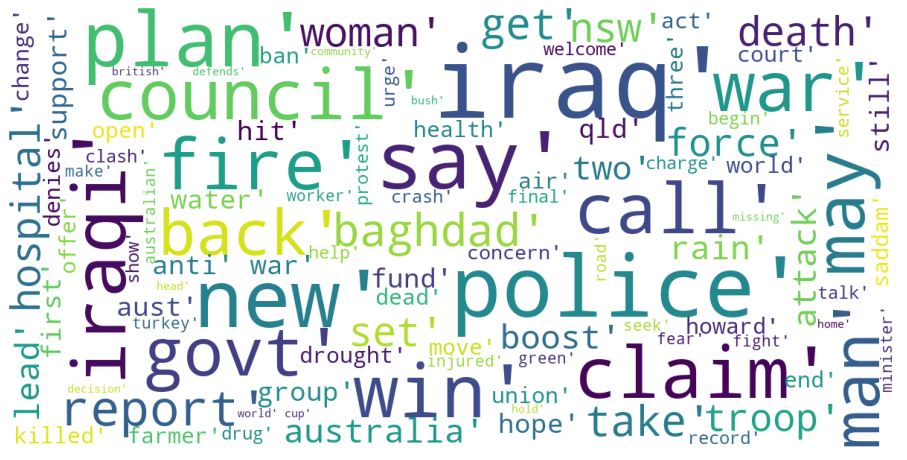

In [32]:
show_wordcloud(corpus)

### Sentiment Analysis

In [33]:
from textblob import TextBlob

In [48]:
TextBlob("100 people killed in Iraq").sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

In [49]:
news['polarity_score'] = news['headline_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

<AxesSubplot:>

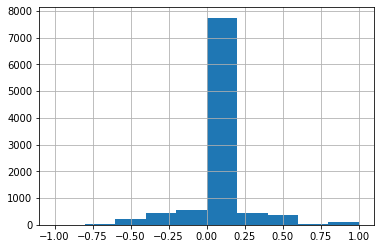

In [51]:
news['polarity_score'].hist()

In [52]:
def sentiment(sent):
    return 'positive' if sent > 0 else ('negative' if sent < 0 else 'neutral')

In [56]:
news['polarity'] = news['polarity_score'].apply(sentiment)

<BarContainer object of 3 artists>

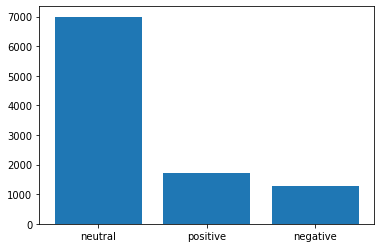

In [58]:
plt.bar(news['polarity'].value_counts().index, news['polarity'].value_counts())

### Named Entity Recognition (NER)

In [59]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [65]:
doc=nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

In [66]:
[(x.text, x.label_) for x in doc.ents]

[('India', 'GPE'), ('Iran', 'GPE'), ('Chabahar', 'NORP'), ('Thursday', 'DATE')]

In [67]:
from spacy import displacy

In [68]:
displacy.render(doc, style='ent')

In [69]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = news['headline_text'].apply(lambda x: ner(x))

ent = [x for sub in ent for x in sub]

In [95]:
counter = Counter(ent)
count = counter.most_common()

<AxesSubplot:>

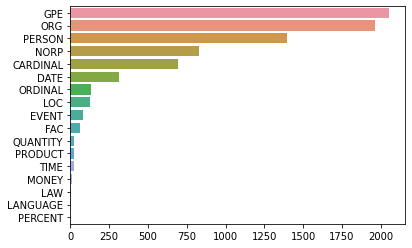

In [96]:
x, y = map(list, zip(*count))
sns.barplot(x=y, y=x)

### Most Common Singular Noun (Tagged with 'NN')

In [91]:
sample_text = news['headline_text'][1]
sample_text

'act fire witnesses must be aware of defamation'

In [92]:
nltk.pos_tag(word_tokenize(sample_text))

[('act', 'NN'),
 ('fire', 'NN'),
 ('witnesses', 'NNS'),
 ('must', 'MD'),
 ('be', 'VB'),
 ('aware', 'JJ'),
 ('of', 'IN'),
 ('defamation', 'NN')]

In [85]:
def get_adjs(text):
    adj = []
    pos = nltk.pos_tag(word_tokenize(text))
    for word, tag in pos:
        if tag == 'NN':
            adj.append(word)
    return adj

words = news['headline_text'].apply(get_adjs)
words = [x for l in words for x in l]

<AxesSubplot:>

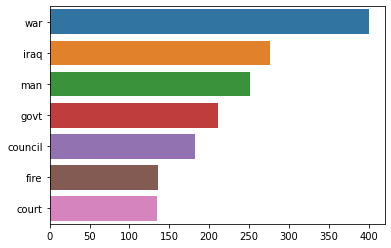

In [86]:
counter = Counter(words)

x, y = list(map(list, zip(*counter.most_common(7))))
sns.barplot(x=y, y=x)

### Flesch Reading Ease (FRE) Score

In [87]:
from textstat import flesch_reading_ease

<AxesSubplot:>

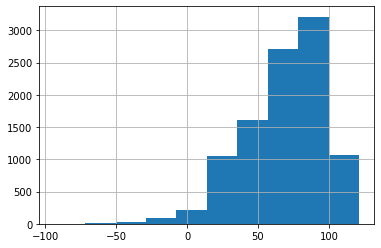

In [88]:
news['headline_text'].apply(flesch_reading_ease).hist()